# Visualization & Plot maker
This notebook loads the results and visualizes them. The outputs of this notebook are plots located in the "../plots" directory for the paper and presentation.


## Load results

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
# Load the CSV file into a pandas DataFrame
from datetime import datetime

import numpy as np

# Set the aesthetics for the seaborn plots
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
plt.rcParams.update({"xtick.labelsize": 17, "ytick.labelsize": 17,
"axes.titlesize": 18, "axes.titleweight": 'bold', "axes.labelsize": 19, "axes.labelweight": 'bold'})
pd.set_option('display.max_columns', 50)


In [2]:
def load_dataframe(path="/n/holyscratch01/barak_lab/Users/ishapira//results/all_results.csv", columns=None):
    # Load the DataFrame
    df = pd.read_csv(path)
    # Convert the 'timestamp' column to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d_%H-%M-%S')

    # Select only the specified columns if the 'columns' parameter is provided
    if columns is not None:
        df = df[columns]

    # Remove rows where 'total weight' is NaN
    df = df.dropna(subset=['total_weights'])
    df = df[(df.regularization != 'dropout') & (df.regularization != 'l_infinty')]
    return df

def create_pivot_table(df, model_name, dataset_name, regularization, metric='test_loss'):
    # Filter the DataFrame based on the input parameters
    filtered_df = df[(df['model_name'] == model_name) & 
                     (df['dataset_name'] == dataset_name) & 
                     (df['regularization'] == regularization)]

    # List of bit widths to consider
    bit_widths = [32, 16, 8, 4, 2]

    # Create a new DataFrame for the pivot table
    pivot_data = []

    for bit in bit_widths:
        if bit == 32:
            # For bit width 32, use the 'test_loss' column
            col_name = metric
        else:
            # For other bit widths, use the 'bit_{i}_{metric}' format
            col_name = f'bit_{bit}_{metric}'

        # Check if the column exists in the DataFrame
        if col_name in filtered_df.columns:
            # Extract the required values and add to the pivot data
            for index, row in filtered_df.iterrows():
                pivot_data.append({'Bit Width': f'bit_{bit}', 
                                   'Regularization Param': row['regularization_param'], 
                                   metric: row[col_name]})

    # Convert the list of data into a DataFrame
    pivot_df = pd.DataFrame(pivot_data)

    # Sort the DataFrame by 'Bit Width' in descending order
    pivot_df['Bit Width'] = pd.Categorical(pivot_df['Bit Width'], 
                                           categories=[f'bit_{b}' for b in bit_widths], 
                                           ordered=True)
    pivot_df = pivot_df.sort_values('Bit Width', ascending=False)

    # Create the pivot table
    pivot_table = pivot_df.pivot(index='Bit Width', columns='Regularization Param', values=metric)

    return pivot_table

def my_eval(x):
    try:
        return eval(x)
    except:
        print(x)
        return x



In [242]:
cols = ['total_weights','model_name', 'dataset_name','regularization', 'regularization_param','optimizer_name',
 'train_loss', 'test_loss', 'train_accuracy', 'test_accuracy','lr', "epoch_test_losses",'path'] + [f'bit_{i}_test_accuracy' for i in [16, 8, 4, 2]]
df = load_dataframe(columns = None)
df.shape

(38, 48)

## Accuracy Heatmaps

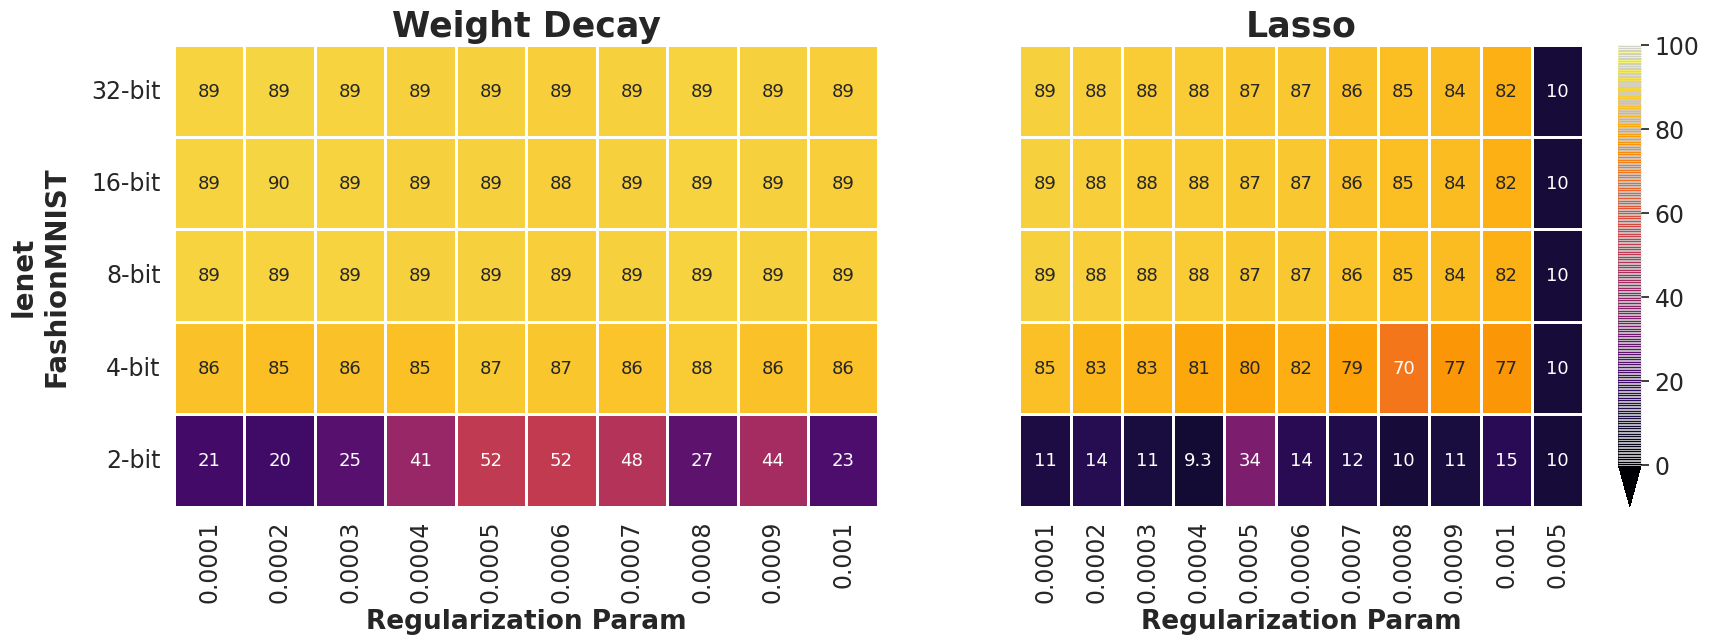

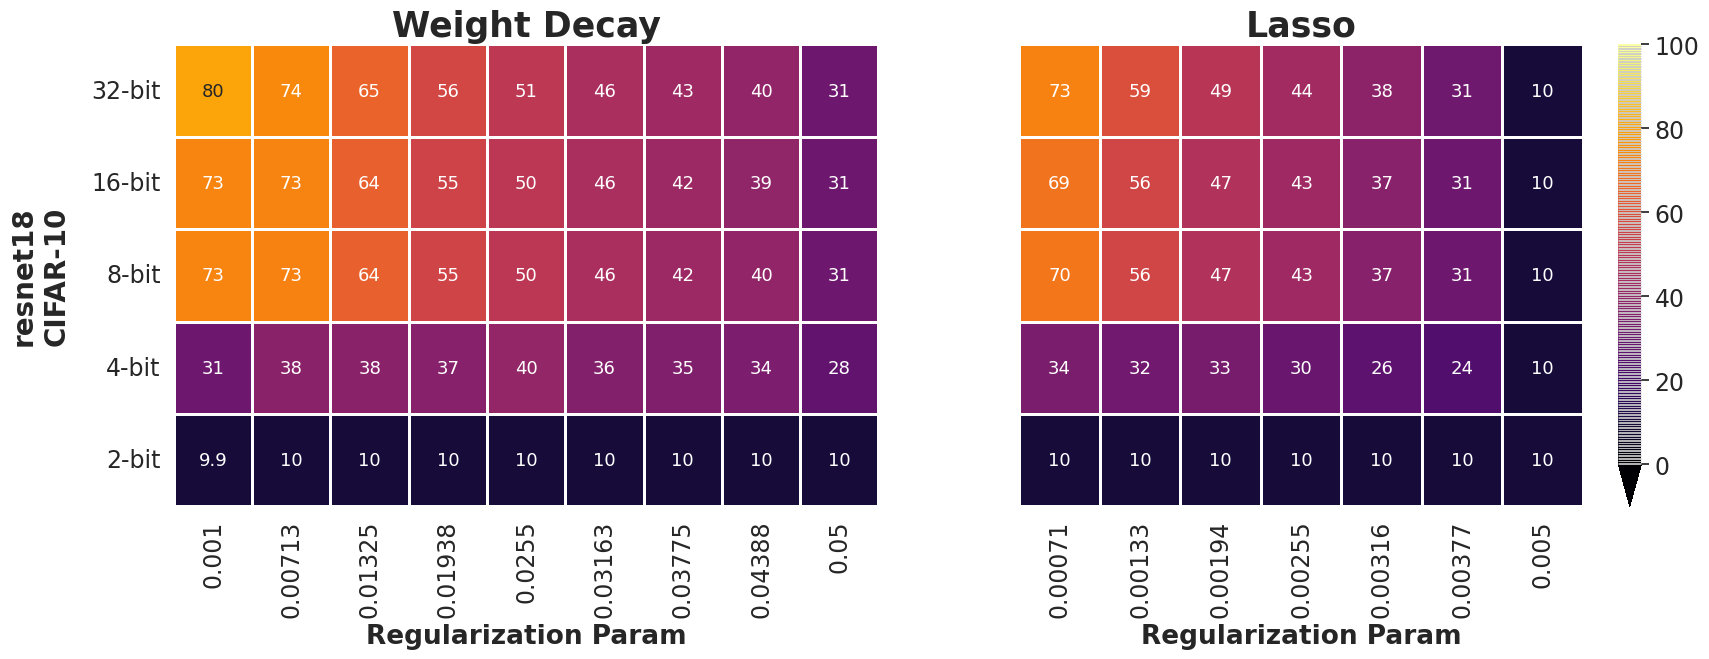

In [72]:


def plot_heatmap(ax, pivot_table, regularization, metric, set_ylabel=True, set_xlabel=True, 
                 model_name='', dataset_name='', title="", show_cbar=True):
    cbar_kws = {"orientation": "vertical", 
                "shrink": 1,
                'extend': 'min', 
                'extendfrac': 0.1, 
                "drawedges": True}

    # Plot heatmap
    sns.heatmap(pivot_table, annot=True, vmin=0, vmax=100, fmt=".2g", annot_kws={'size': 13}, 
                linewidths=1, cmap="inferno", cbar_kws=cbar_kws if show_cbar else None, 
                ax=ax, cbar=show_cbar)

    # Dictionary for renaming tick labels
    rename_dict = {'bit_2': '2-bit', 'bit_4': '4-bit', 'bit_16': '16-bit', 'bit_32': '32-bit', 'bit_8': "8-bit"}

    # Set custom tick labels for quantization levels
    ax.set_xticklabels([rename_dict.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])
    if set_ylabel:
        ax.set_yticklabels([rename_dict.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()], rotation=0)
        ax.set_ylabel(f"{model_name}\n{dataset_name}", rotation=90, labelpad=15, fontsize=20)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
    if not set_xlabel:
        ax.set_xlabel('')
    if title:
        ax.set_title(title, fontsize=25)




metric = 'test_accuracy'
unique_datasets = df['dataset_name'].drop_duplicates().dropna()

for dataset_name in unique_datasets:
    # Filter the unique combinations of model_name and regularization for this dataset
    unique_pairs = df[df['dataset_name'] == dataset_name][['model_name', 'regularization']].drop_duplicates().dropna()

    # Number of plots (subplots) needed for this dataset
    n_plots = 2

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, n_plots, figsize=(10 * n_plots, 6))  # Adjust the size as needed
    titles={"l2":"Weight Decay", "l1":'Lasso'}
    for i, (model_name, regularization) in enumerate(unique_pairs.values):
        if regularization != "none":
            tmp = df[
                (df.model_name == model_name) & (df.dataset_name == dataset_name) & (df.regularization == regularization)
            ]
            pivot_table = create_pivot_table(tmp, model_name, dataset_name, regularization, metric)

            # Plot heatmap in the ith subplot
            if n_plots > 1:
                ax = axes[i]
            else:
                ax = axes  # If there's only one plot, axes is not a list
            plot_heatmap(ax, pivot_table, regularization, metric, (i==0), True, model_name, dataset_name, title=titles[regularization], show_cbar=(i!=0))

    # Save the entire figure as a PNG file
    fig.savefig(f"../plots/test_accuracy_{dataset_name}.png", bbox_inches='tight')
    plt.show()  # Display the figure

    # This loop will create a single figure for each dataset, with multiple subplots in a row


In [ ]:


def plot_heatmap(ax, pivot_table, regularization, metric, set_ylabel=True, set_xlabel=True, 
                 model_name='', dataset_name='', title="", show_cbar=True):
    cbar_kws = {"orientation": "vertical", 
                "shrink": 1,
                'extend': 'min', 
                'extendfrac': 0.1, 
                "drawedges": True}

    # Plot heatmap
    sns.heatmap(pivot_table, annot=True, vmin=0, vmax=100, fmt=".2g", annot_kws={'size': 13}, 
                linewidths=1, cmap="inferno", cbar_kws=cbar_kws if show_cbar else None, 
                ax=ax, cbar=show_cbar)

    # Dictionary for renaming tick labels
    rename_dict = {'bit_2': '2-bit', 'bit_4': '4-bit', 'bit_16': '16-bit', 'bit_32': '32-bit', 'bit_8': "8-bit"}

    # Set custom tick labels for quantization levels
    ax.set_xticklabels([rename_dict.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])
    if set_ylabel:
        ax.set_yticklabels([rename_dict.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()], rotation=0)
        ax.set_ylabel(f"{model_name}\n{dataset_name}", rotation=90, labelpad=15, fontsize=20)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
    if not set_xlabel:
        ax.set_xlabel('')
    if title:
        ax.set_title(title, fontsize=25)




metric = 'test_accuracy'
unique_datasets = df['dataset_name'].drop_duplicates().dropna()

for dataset_name in unique_datasets:
    # Filter the unique combinations of model_name and regularization for this dataset
    unique_pairs = df[df['dataset_name'] == dataset_name][['model_name', 'regularization']].drop_duplicates().dropna()

    # Number of plots (subplots) needed for this dataset
    n_plots = 2

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, n_plots, figsize=(10 * n_plots, 6))  # Adjust the size as needed
    titles={"l2":"Weight Decay", "l1":'Lasso'}
    for i, (model_name, regularization) in enumerate(unique_pairs.values):
        if regularization != "none":
            tmp = df[
                (df.model_name == model_name) & (df.dataset_name == dataset_name) & (df.regularization == regularization)
            ]
            pivot_table = create_pivot_table(tmp, model_name, dataset_name, regularization, metric)

            # Plot heatmap in the ith subplot
            if n_plots > 1:
                ax = axes[i]
            else:
                ax = axes  # If there's only one plot, axes is not a list
            plot_heatmap(ax, pivot_table, regularization, metric, (i==0), True, model_name, dataset_name, title=titles[regularization], show_cbar=(i!=0))

    # Save the entire figure as a PNG file
    fig.savefig(f"../plots/test_accuracy_{dataset_name}.png", bbox_inches='tight')
    plt.show()  # Display the figure

    # This loop will create a single figure for each dataset, with multiple subplots in a row


## Distribution shift

In [178]:

# Assuming 'df' is your DataFrame with model information
ridge_data = {}

for index, row in df[(df.dataset_name == "CIFAR-10") & (df.regularization == "l2")].sort_values('regularization_param').iterrows():
    path = os.path.join(row['path'], "model_checkpoint.pth")
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    weights = checkpoint['model.layer2.0.conv1.weight'].numpy().flatten()
    ridge_data[row['regularization_param']]=weights

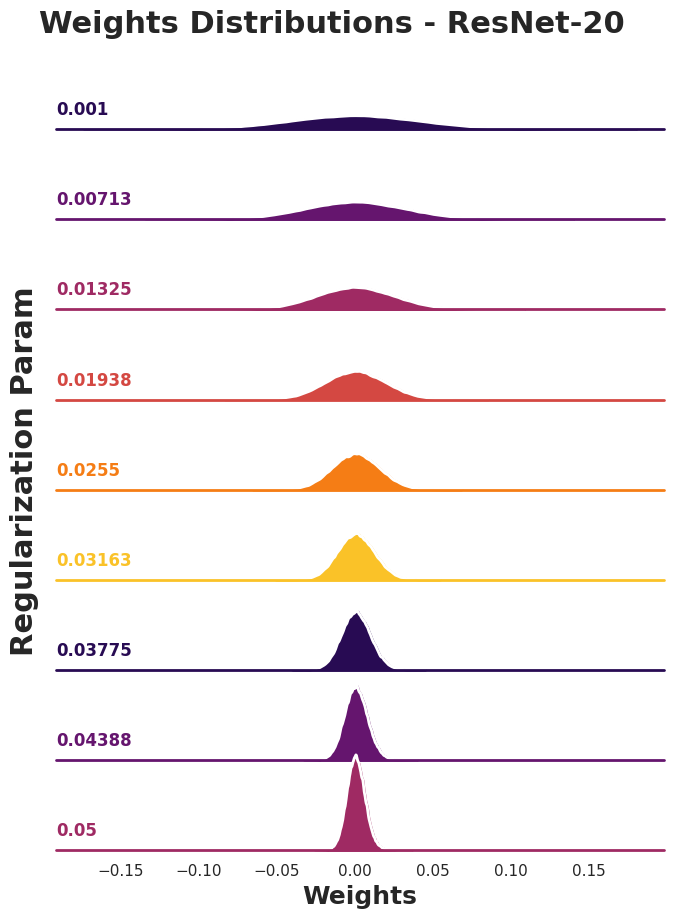

In [241]:
# Convert dictionary to DataFrame
data = []
for key, values in ridge_data.items():
    for value in values:
        data.append({'Regularization': key, 'Value': value})
ridge_df = pd.DataFrame(data)

# Sort DataFrame based on Regularization values
ridge_df = ridge_df.sort_values('Regularization')

subplot_height = 1  # Adjust this value as needed
aspect_ratio = 7     # Adjust this value to control the width of each subplot

# Choose the palette
palette_choice = sns.color_palette("inferno")

# Initialize the FacetGrid object
g = sns.FacetGrid(ridge_df, row='Regularization', hue='Regularization', aspect=aspect_ratio, height=subplot_height, palette=palette_choice)

# Draw the densities
g.map(sns.kdeplot, 'Value', bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'Value', clip_on=False, color="w", lw=2, bw_adjust=.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Function to label the plot
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, 'Value')

# Set the subplots to overlap and adjust aesthetics
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Add X-axis title and increase font size
g.set_axis_labels("Weights", fontsize=18)
g.fig.text(0.04, 0.5, 'Regularization Param', va='center', rotation='vertical', fontsize=22, fontweight='bold')

# Add a main title to the figure
g.fig.suptitle("Weights Distributions - ResNet-20", fontsize=22, va="bottom", fontweight='bold')
g.figure.subplots_adjust(hspace=-.1, top=0.99)  # Adjust the top value as needed

g.fig.savefig("../plots/ridge_distribution_plot.png", dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

In [395]:
def get_std(path, layer='model.layer2.0.conv1.weight'):
    path = os.path.join(path, "model_checkpoint.pth")
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    try:
        weights = checkpoint[layer].numpy().flatten()
    except:
        weights = checkpoint['conv1.weight'].numpy().flatten()

    return np.sqrt(np.mean(weights**2))#weights.std()*np.sqrt(weights.shape[0] )

In [394]:


path = '/n/home12/ishapira/git_connection/TinyML-RegulizationAndQuantization/results/ishapira_lenet_FashionMNIST_l2_0.0002_2023-11-19_15-03-30/model_checkpoint.pth'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
for k in checkpoint:
    print(k, checkpoint[k].shape)

conv1.weight torch.Size([6, 1, 5, 5])
conv1.bias torch.Size([6])
conv2.weight torch.Size([16, 6, 5, 5])
conv2.bias torch.Size([16])
fc1.weight torch.Size([120, 256])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])


In [396]:
tmp = df
tmp["std"] = tmp['path'].apply(get_std)
tmp['drop'] = tmp['bit_8_test_accuracy']-tmp['test_accuracy']

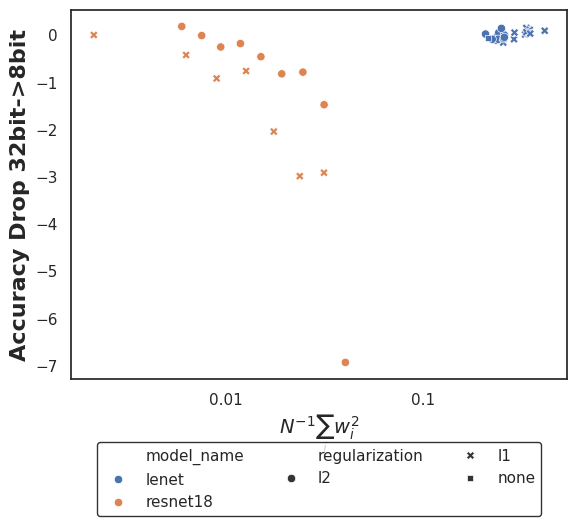

In [404]:
# Your existing scatterplot code
ax = sns.scatterplot(data=tmp[tmp['std'] > 0.001], x="std", y="drop", hue="model_name", style="regularization")

# Change the x-axis to logarithmic scale
ax.set_xscale('log')

# Use LogFormatter for better tick formatting
ax.xaxis.set_major_formatter(ticker.LogFormatter())

# Set major and minor ticks on the x-axis
#ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
#ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(0.1, 1, 0.1), numticks=100))

# Set the formatter for the major ticks
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.tick_params(axis='x', which='minor', length=4)  # Adjust the length as needed

# Ensure that the major ticks are formatted to look nice
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:g}'))

# Change axis titles and increase font size
ax.set_xlabel("$N^{-1}\sum_i w_i^2$", fontsize=14)
ax.set_ylabel("Accuracy Drop 32bit->8bit", fontsize=16)

# Add a plot title
#ax.set_title("Variance", fontsize=16)

# Adjust the legend
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(tmp['regularization'].unique()), frameon=True)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_edgecolor('black')
plt.savefig("../plots/variance.png", dpi=500, bbox_inches='tight')

# Show the plot
plt.show()